
# The *grmpy*  package 
This notebook demonstrates the current capabilities of the *grmpy* package. *grmpy* is an open source package for the programming language python that enables researchers to simulate datasets andestimate parameters using already existing data within the structure of the generalized Roy model. Currently the package serves as a teaching tool for a course on the econometrics of policy evaluation at the University of Bonn. The corresponding lecture materials can be found on [GitHub](https://github.com/HumanCapitalAnalysis/econometrics).  Morover it is thought of as a promotion for the conceptual framework as well as a showcase for basic software engineering practices.

For a more detailed overview on the economic background as well as the installation routine feel free to take a look on the [online documentation](https://grmpy.readthedocs.io/en/develop/).

The notebook itself is divided in three parts. Firstly we provide a basic outline on how to use the package and introduce the core features. Next we will show that the results obtained by the package's estimation process withstand a critical examination by comparing its performance in the presence of essential heterogeneity with several other estimation approaches like Ordinary Least Squares and Instrumental variables. We conclude by conducting a replication of results from   

Carneiro, P., Heckman, J. J., & Vytlacil, E. J. (2011). [Estimating marginal returns to education.](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.101.6.2754)
*American Economic Review, 101*(6), 2754-81.


# The Framework

As mentioned before the package makes use of the normal-linear-in-parameters version generalized Roy model. In addition we assume that the unobservable terms $\{U_1, U_0, V\}$ are normally distributed according to the covariance matrix $\Sigma$. The following set of equations characterize the underlying model:
\begin{align*}
 &\textbf{Potential Outcomes} & & \textbf{Choice}  &\\
 & Y_1 = \beta_1 X + U_{1} &  &D_i = \mathbf{1}\{\Phi(\gamma Z) > u_D\} &\\
 & Y_0 = \beta_0 X + U_{0} &  & \text{with $u_D = \Phi(V)$}  &\\
&&&&\\
&\textbf{Distributional Characteristics}&&&\\
&\{U_{1}, U_{0}, V\} \sim \mathcal{N}\left(0, \Sigma\right)&&\Sigma =  \begin{bmatrix}
    \sigma_1^{2} & \sigma_{1,0} & \sigma_{1,V} \\
    \sigma_{1,0} & \sigma_0^{2} & \sigma_{0,V} \\
    \sigma_{1,V} & \sigma_{0,V} & \sigma_V^{2} \\
  \end{bmatrix}&\\
&&&&\\
& \textbf{Observed Outcome} &&&\\
& Y = D Y_1 + (1-D) Y_0 &&&
\end{align*}


# Preliminaries

The first step consists of some style and import improving settings.

In [56]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Before we can start with the application examples we have to import several libaries that we rely on during this presentation.

In [33]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import json

import grmpy

In addition we will import some custom functions for plotting several figures of interest as well as some data management purposes. The code is provided in the auxiliary.py file.

In [58]:
from auxiliary import plot_joint_distribution_unobservables
from auxiliary import plot_joint_distribution_potential
from auxiliary import plot_marginal_effects
from auxiliary import process_data
from auxiliary import plot_est_mte
from auxiliary import monte_carlo
from auxiliary import effects

# Part I - Introduction

This part provides some basic information about the general application of the package's core methods. 

## The initialization file

Currently the package has two core features. The first one is the simulation process. It enables users to simulate data sets along a pre-specified parameterization. The data generating process follows the structure of the previously introduced parametric Roy model framework. Therefore users specify their desired parametrization in an initialization file which allows altering any aspects of the model according to their preferences. The ability to estimate parameters on already existing data sets is the second core feature. As before the initialization file is the starting point for the estimation process. 

The initialization file is structured as follows:

* **Simulation**: The simulation section contains information for the estimation process. For instance users are able to change the number of individuals for which the program runs a simulation through setting the agents option to a specific value.


* **Estimation**: Accordingly information regarding the estimation process are stored in the estimation section. Here, users can set the type of optimizer which should be used for running the process as well as the maximum number of iterations that the process is allowed to perform. In addition the flags *dependent* and *indicator* determine which variable of the input data frame is seen as the dependent variable and the treatment indicator variable, respectively.


* **Treated, Untreated, Choice**: These sections are essential for both methods. They contain the parameterization which is used for the simulation process. Additionally the second column indicates the variable labels well as for the simulated data set. This column is also essential for the estimation process because it will only include variables that are pre-specified in a specific section for the following optimization.


* **Dist**: The Dist section determines the distributional characteristics of the unobservable variables. Therefore the section reports the upper triangle of the covariance matrix of $(U_1, U_0,V)$.


* **SCIPY-BFGS/SCIPY-POWELL**: The SCIPY-related sections contain options for the relevant optimization algorithms.

In [35]:
%%file files/tutorial.grmpy.ini
   SIMULATION

        agents                     10000
        seed                       2356
        source                     data

   ESTIMATION

        file                       data.grmpy.txt
        output_file                output/est.grmpy.info
        optimizer                  SCIPY-BFGS
        start                      auto
        maxiter                    6383
        agents                     165 
        dependent                  Y
        indicator                  D
        comparison                 1




   TREATED

        coeff          const      1.0000
        coeff          X2         0.5550

   UNTREATED

        coeff          const      0.5000
        coeff          X2         0.2500

   CHOICE

        coeff          const      0.3780
        coeff          X3        -0.3900

   DIST

        coeff                    0.1000
        coeff                    0.0000
        coeff                    0.0000
        coeff                    0.1000
        coeff                    0.0000
        coeff                    1.0000

   SCIPY-BFGS

        gtol                    0.00001
        eps                     1.4901161193847655e-08

   SCIPY-POWELL

        xtol                     9.147777614048603e-05
        ftol                     9.749582129043358e-05


Overwriting files/tutorial.grmpy.ini


## The Simulation Process

For simulating a dataset we only have to provide the package with the related inititalization file.

In [36]:
data = grmpy.simulate('files/tutorial.grmpy.ini')
data.head()

,Y,D,const,X2,X3,Y1,Y0,U1,U0,V
0,0.557775,0,1.0,-0.014710,0.023439,0.994512,0.557775,0.002676,0.061452,0.767310
1,2.164590,1,1.0,1.941447,-1.375891,2.164590,1.051813,0.087087,0.066451,-0.567979
2,0.956087,1,1.0,-0.220668,1.555453,0.956087,0.452973,0.078557,0.008140,-0.307828
3,1.289630,1,1.0,0.531899,0.192161,1.289630,0.688027,-0.005574,0.055052,-1.129202
4,0.503965,0,1.0,-0.295161,1.663835,0.724652,0.503965,-0.111534,0.077755,-0.024787


The simulation process generates an info file that provides additional information about the distribution of outcomes and effects, respectively. Additionally it contains the criterion function value, information about the corresponding marginal treatment effects as well as the paramterization.

In [57]:
!cat "data.grmpy.info"




 Number of Observations 

                            Count

  All                       10000
  Treated                    6391
  Untreated                  3609


 Distribution of Outcomes

                             Mean             Std-Dev.                  25%                  50%                  75%

  All                      0.8196               0.5328               0.4401               0.7467               1.1652
  Treated                  1.0018               0.5580               0.6305               1.0059               1.3721
  Untreated                0.4968               0.2689               0.3218               0.5001               0.6782


 Distribution of Effects

                             Mean             Std-Dev.                  25%                  50%                  75%

  All                      0.4998               0.3340               0.2739               0.4974               0.7208
  Treated                  0.5007               0.3354              

The generated data set is specififed so that the treatment selection process is not affected by essential heterogeneity. Therefore the conventional effects are nearly identical. 

ATE: 0.49983004856551627
TT:  0.500730693488769
TUT: 0.4982351409167191 



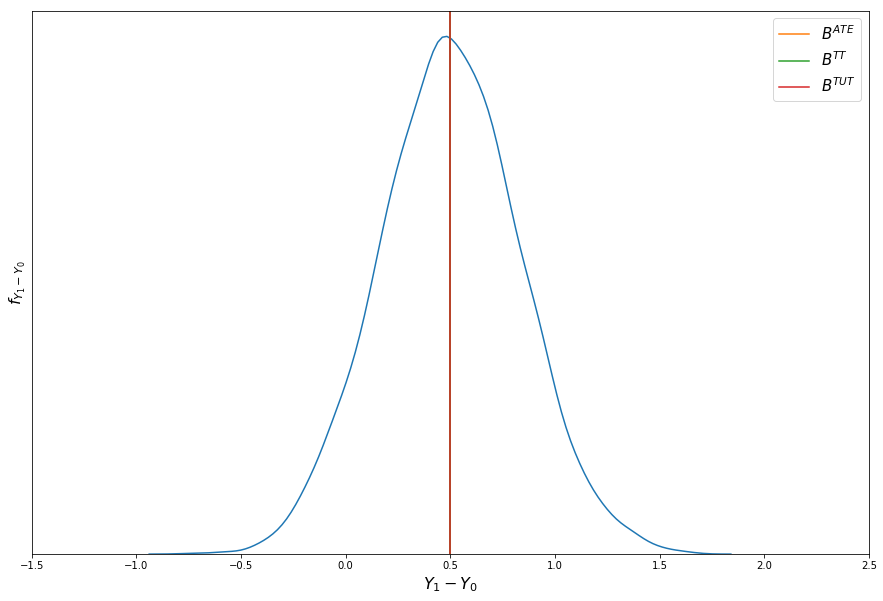

In [38]:
effects(data)

### Essential Heterogeneity
For providing an example on how essential heterogeneity biases the results obtained by naive comparison between treated and untreated individuals, we alter the initialization file. Specifically we will introduce correlation between the unobservable terms. This leads to the situation where individuals select into treatment based on unobservable gains. Therefore the treatment decision $D$ is no longer independent from the outcomes $Y_1$ and $Y_0$.

\begin{align}
Y_1,Y_0\;\; {\perp\!\!\!\!\!\!\diagup\!\!\!\!\!\!\!\perp} \;\; D
\end{align}

Unlike in the absence of essential heterogeneity individuals who select themselves into treatment differ from
individuals who do not with respect to their unobservable characteristics. From this follows that

\begin{align}
B^{ATE} \neq B^{TT} \neq B^{TUT}
\end{align}

In [39]:
%%file files/tutorial_eh.grmpy.ini
   SIMULATION

        seed                                      2356
        agents                                   10000
        source                                 data_eh

   ESTIMATION

        file                         data_eh.grmpy.txt
        start                                     auto
        agents                                     165
        optimizer                           SCIPY-BFGS
        maxiter                                   6383
        dependent                                    Y
        indicator                                    D
        output_file               output/est.grmpy.info
        comparison                                   1

   TREATED

        coeff               const               1.0000
        coeff                  X2               0.5550

   UNTREATED

        coeff               const               0.5000
        coeff                  X2               0.2500

   CHOICE

        coeff               const               0.3780
        coeff                  X3              -0.3900

   DIST

        coeff                                   0.1000
        coeff                                   0.0000
        coeff                                   0.0524
        coeff                                   0.1000
        coeff                                  -0.0216
        coeff                                   1.0000

   SCIPY-BFGS

        gtol                                     1e-05
        eps                     1.4901161193847655e-08

   SCIPY-POWELL

        xtol                     9.147777614048603e-05
        ftol                     9.749582129043358e-05



Overwriting files/tutorial_eh.grmpy.ini


In [40]:
data_eh = grmpy.simulate('files/tutorial_eh.grmpy.ini')
data_eh.head()

,Y,D,const,X2,X3,Y1,Y0,U1,U0,V
0,0.976807,1,1.0,-0.014710,0.023439,0.976807,0.568986,-0.015029,0.072663,-0.767427
1,2.198912,1,1.0,1.941447,-1.375891,2.198912,1.007191,0.121409,0.021829,0.563892
2,0.421079,0,1.0,-0.220668,1.555453,0.956515,0.421079,0.078986,-0.023754,0.304143
3,0.661060,0,1.0,0.531899,0.192161,1.371525,0.661060,0.076321,0.028085,1.129450
4,0.532464,0,1.0,-0.295161,1.663835,0.782446,0.532464,-0.053739,0.106255,0.030013


In [41]:
!cat "data_eh.grmpy.info"




 Number of Observations 

                            Count

  All                       10000
  Treated                    6384
  Untreated                  3616


 Distribution of Outcomes

                             Mean             Std-Dev.                  25%                  50%                  75%

  All                      0.7945               0.5279               0.4237               0.7200               1.1301
  Treated                  0.9721               0.5557               0.6012               0.9698               1.3457
  Untreated                0.4809               0.2674               0.3072               0.4807               0.6615


 Distribution of Effects

                             Mean             Std-Dev.                  25%                  50%                  75%

  All                      0.4987               0.3328               0.2705               0.5020               0.7210
  Treated                  0.4607               0.3279              

ATE: 0.4987192962464583
TT:  0.46070333176413386
TUT: 0.5658359769033056 



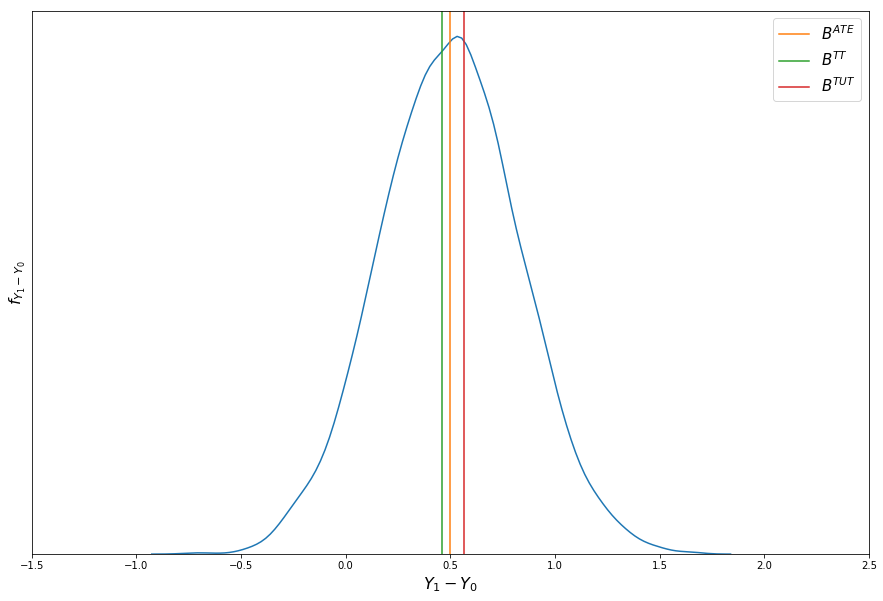

In [42]:
effects(data_eh)

Next we illustrate how essential heterogeneity is refelected in the joint distribution of the error term. For that purpose we created two figures that show the relationship between $U_1$ and $V$ for both data sets which we simulated before.

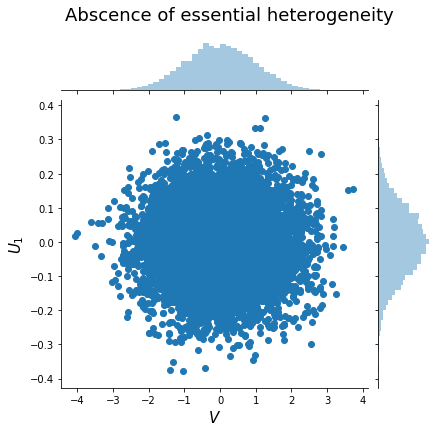

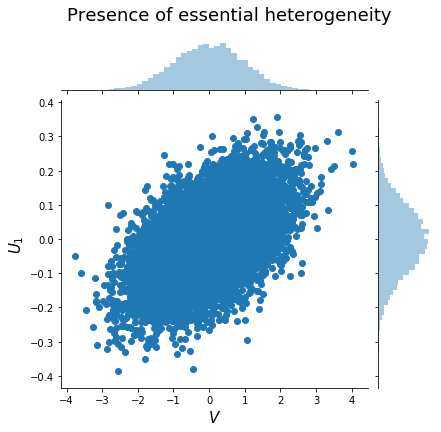

In [43]:
plot_joint_distribution_unobservables(data, data_eh)

Simulating data sets enables us to explore more facets of the impact of essential heterogeneity on the marginal effect of treatment. The marginal effect of treatment, henceforth denoted as $B^{MTE}$ is defined as the effect of treatment for individuals that are indifferent between taking the treatment or not along the distribution of the unobservable variable $V$. This means that instead of assigning explicitly one value as the effect of treatment the $B^{MTE}$ provides a continuum of effects along the distribution of the unobservable $V$. More formally:

\begin{align*}
B^{MTE} = E[Y_1-Y_0|X=x, U_D = u_D] \\
\end{align*}

In the abscence of essential heterogeneity $B^{MTE}$ provides a constant value over the whole distribution of $V$. This implies that the individual's decision for treatment participation is independent of their unobservable benefits so that each individual on the margin faces the same average benefit of treatment. This can be seen in the figure below. The flat line captures the $B^{MTE}$ for the simulated data without essential heterogeneity, wheras the increasing cure illustrates the marginal effect for the one that is affected by essential heterogeneity.

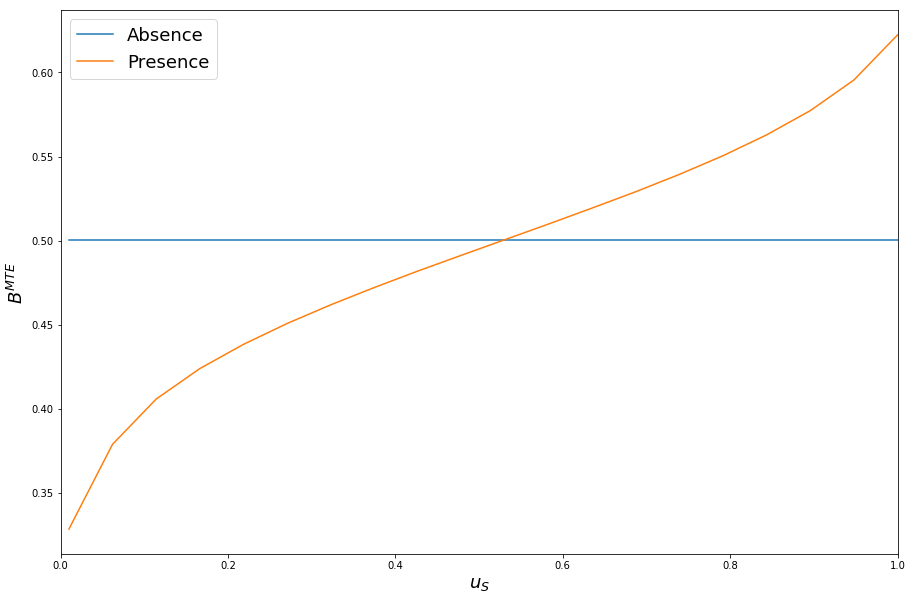

In [44]:
plot_marginal_effects('data.grmpy.info', 'data_eh.grmpy.info')

Using simulated data allows us to tackle issues and explore additional objects of interest for which we are not able to obtain reliable information if we use empirical data sets. For instance we are able to construct the joint distribution of potential outcomes from the previously simulated data sets because our simulated data allows us to evade the evaluation problem. This means that we have information about the whole space of potential outcomes for each individual. 

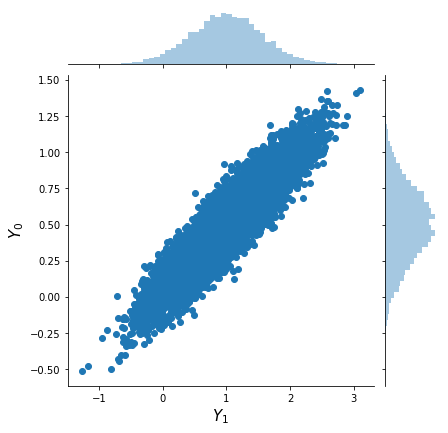

In [45]:
plot_joint_distribution_potential(data_eh)

## The Estimation Process

grmpy enables users to estimate parameters on data sets. Executing an estimation is simple. Just setup your estimation specifications in the initialization file and provide the estimation process with the resulting initialization file.

In [47]:
rslt = grmpy.fit('files/tutorial_eh.grmpy.ini')

The estimation process returns a detailed overview of the results via an output file

In [ ]:
# %load output/est.grmpy.info

 
  Optimization Information

             Optimizer:                               SCIPY-BFGS
             Start values:                            auto
             Success:                                 1
             Status:                                  0
             Number of Evaluations:                   276
             Criterion:                              -0.3230
             Message:                                 Optimization terminated successfully.

             Warning:                                 The optimization algorithm has failed to provide the parametrization that leads to the minimal criterion function value. 
                                                      The estimation output is automatically adjusted.


 
  Criterion Function

                                        Start               Finish


                         -0.31874068025449437  -0.3229750696988168


 
  Economic Parameters


                                    Start          Finish

 Section       Identifier           Coef           Coef        Std err      95% Conf. Int.

  TREATED    
               const                0.9708         0.9981      (0.0031)    0.9920    1.0042
               X2                   0.5533         0.5533      (0.0012)    0.5510    0.5556

  UNTREATED  
               const                0.4805         0.4953      (0.0064)    0.4827    0.5078
               X2                   0.2477         0.2477      (0.0017)    0.2445    0.2510

  CHOICE     
               const                0.3795         0.3796      (0.0133)    0.3535    0.4056
               X3                  -0.4175        -0.4145      (0.0141)   -0.4420   -0.3870

  DIST       
               sigma1               0.0936         0.0998      (0.0016)    0.0967    0.1029
               rho1                 0.0000         0.5055      (0.0457)    0.4159    0.5952
               sigma0               0.1002         0.1009      (0.0013)    0.0983    0.1036
               rho0                 0.0000        -0.1528      (0.0631)   -0.2765   -0.0290


In addition the process is capable of simulating a new data set according to the estimation results. This enables users to verify their obtained results easily.

In [ ]:
# %load comparison.grmpy.txt


 Number of Observations 

    Sample                                Observed   Simulated (finish)    Simulated (start)


    All                                      10000                10000                10000
    Treated                                   6384                 6374                 6398
    Untreated                                 3616                 3626                 3602


 Distribution of Outcomes



   All       

                                              Mean             Std-Dev.                  25%                  50%                  75%

    Observed Sample                         0.7945               0.5279               0.4237               0.7200               1.1301
    Simulated Sample (finish)               0.7941               0.5261               0.4249               0.7196               1.1309
    Simulated Sample (start)                0.7944               0.5281               0.4204               0.7235               1.1358


   Treated   

                                              Mean             Std-Dev.                  25%                  50%                  75%

    Observed Sample                         0.9721               0.5557               0.6012               0.9698               1.3457
    Simulated Sample (finish)               0.9721               0.5538               0.5985               0.9700               1.3458
    Simulated Sample (start)                0.9726               0.5546               0.6072               0.9752               1.3414


   Untreated 

                                              Mean             Std-Dev.                  25%                  50%                  75%

    Observed Sample                         0.4809               0.2674               0.3072               0.4807               0.6615
    Simulated Sample (finish)               0.4812               0.2658               0.3086               0.4804               0.6620
    Simulated Sample (start)                0.4778               0.2673               0.3040               0.4816               0.6576


 MTE Information 

    Quantile                Value

          1%               0.3503
          5%               0.3951
         10%               0.4191
         15%               0.4352
         20%               0.4480
         25%               0.4590
         30%               0.4689
         35%               0.4781
         40%               0.4868
         45%               0.4952
         50%               0.5035
         55%               0.5117
         60%               0.5201
         65%               0.5288
         70%               0.5380
         75%               0.5479
         80%               0.5589
         85%               0.5717
         90%               0.5878
         95%               0.6118
         99%               0.6566


## Software Engineering Practices


# Part II - Monte Carlo Simulation

For illustrating the advantages of grmpy's estimation process in the presence of essential heterogeneity we conduct a Monte Carlo exercise. As before the starting point of the exericise is an initialization file over which we iterate several times during the process. The distributional characteristics are such that the unobservable variables are distributed according to the following covariance matrix

\begin{align}
\Sigma =  \begin{bmatrix}
    0.01 & 0 & \frac{\rho_{1,V}}{0.1}  \\
    0 & 0.01 & 0 \\
    \frac{\rho_{1,V}}{0.1}  & 0 & 1 \\
  \end{bmatrix}
\end{align}

During each step of the iteration we increase the correlation between $U_1$ and $V$. We will start from a value of $\rho_1 =0.0$ and end at $\rho_1 = 0.99$. This increase is equivalent to the observation of incremental reverse selection behavior, because individuals with a low value of $V$ which are most likely to select into treatment have on average a lower value of $U_1$ than individuals that have larger values of $V$. in addition we estimate the average effect of treatment during each step. For this purpose we use the grmpy estimation process, an ordinary least squares regression and an instrumental variables approach as well as a naive comparison of outputs between treated and untreated individuals.



### The Initialization file

In [59]:
%%file files/mc.grmpy.ini

   SIMULATION

        seed                                    51353
        agents                                   10000
        source                                      mc

   ESTIMATION

        file                              mc.grmpy.txt
        start                                     auto
        agents                                     165
        optimizer                           SCIPY-BFGS
        maxiter                                   6383
        dependent                                 wage
        indicator                                state
        output_file                 mc_rslt.grmpy.info
        comparison                                   0

   TREATED

        coeff               const               0.9900
        coeff                  X2               0.5550
        coeff                  X3              -0.5550
        coeff                  X4               0.7550
        coeff                  X5               0.1550

   UNTREATED

        coeff               const               0.5000
        coeff                  X2               0.2550
        coeff                  X3              -0.2550
        coeff                  X4               0.1768
        coeff                  X5               0.0987

   CHOICE

        coeff               const               0.2280
        coeff                  X6              -0.3900
        coeff                  X7               0.5900
        coeff                  X8              -0.0900
        coeff                  X9              -0.3300

   DIST

        coeff                                   0.1000
        coeff                                   0.0000
        coeff                                   0.0000
        coeff                                   0.1000
        coeff                                   0.0000
        coeff                                   1.0000

   SCIPY-BFGS

        gtol                                     1e-05
        eps                     1.4901161193847655e-08

   SCIPY-POWELL

        xtol                     9.147777614048603e-05
        ftol                     9.749582129043358e-05



Overwriting files/mc.grmpy.ini


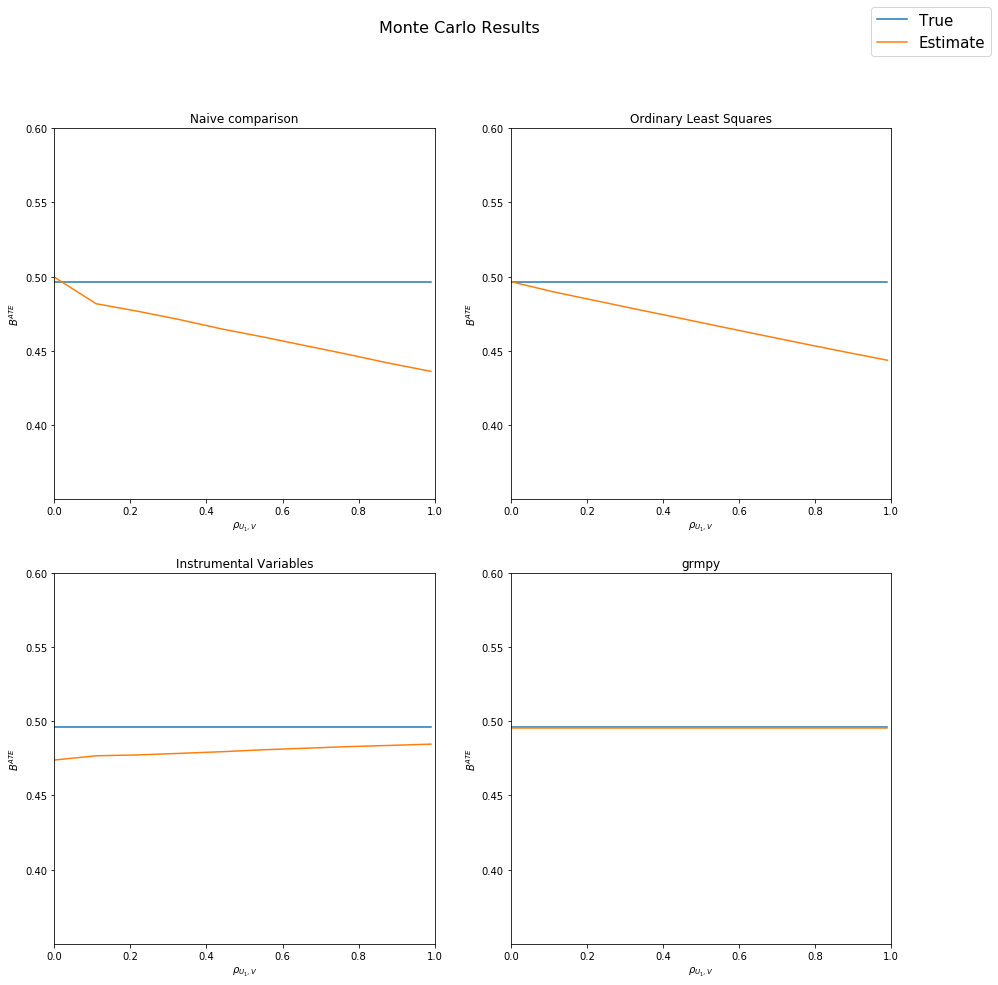

In [60]:
grmpy.simulate('files/mc.grmpy.ini')
monte_carlo('files/mc.grmpy.ini', 10)

As can be seen from the figure, the OLS estimator and the naive comparison of outcomes between the treated and untreated subpopulation underestimate the effect significantly. The stronger the correlation between the unobservable variables the more or less stronger bias. Moreover the IV estimates become upward biased as soon the impact of essential heterogeneity increases. Conversely to the other estimation approaches the grmpy estimate of the average effect is close to the true value even if the unobservables are almost perfectly correlated.

# Part III - Replication Carneiro & Heckman & Vytlacil 2011

Since the current version of grmpy is not capable of estimating non-parametric versions of the Roy models, our
replication of Carneiro et al. (2011) will focus on reproducing the results for the marginal treatment effect of the parametric selection model. Due to reasons of privacy regarding local variables, we are not able to merge the data provided by the authors so that they fully coincide with the original data set. Therefore our replication setup makes use of a mock data set. For this purpose we randomly merge the individual specific data with the local characteristics.

In [52]:
basic = pd.read_stata('data/basicvariables.dta')
local = pd.read_stata('data/localvariables.dta') 
df = pd.concat([basic, local], axis = 1)
process_data(df,'data/aer-replication-mock')

In the next step we have to create a inititalization file that fully coincides with the setup by Carneiro et. al. (2011). Therefore we use the information that the authors provide in their appendix to create the following init file:

In [53]:
%%file files/replication.grmpy.ini
   SIMULATION

        seed                                         5062
        agents                                        991
        source                                   8EF73AA0

   ESTIMATION

        file                                         data/aer-replication-mock.pkl
        start                                        auto
        agents                                       1000
        optimizer                                    SCIPY-BFGS
        maxiter                                      80000
        dependent                                    wage
        indicator                                    state
        output_file                                  replication.grmp.info
        comparison                                   0


   TREATED

        coeff                   const                 1.0
        coeff                   exp                   0.0794
        coeff                   expsq                -0.0035
        coeff                   lwage5                0.8319
        coeff                   lurate                0.0032
        coeff                   cafqt                 0.1222
        coeff                   cafqtsq               0.0546
        coeff                   mhgc                 -0.0097
        coeff                   mhgcsq                0.0014
        coeff                   numsibs              -0.0102
        coeff                   numsibssq             0.0002
        coeff                   urban14               0.0457
        coeff                   lavlocwage17          0.8999
        coeff                   lavlocwage17sq       -0.0431
        coeff                   avurate               0.1459
        coeff                   avuratesq            -0.0135
        coeff                   d57                   1.0
        coeff                   d58                   1.0
        coeff                   d59                   1.0
        coeff                   d60                   1.0
        coeff                   d61                   1.0
        coeff                   d62                   1.0
        coeff                   d63                   1.0

   UNTREATED

        coeff                   const                 1.0
        coeff                   exp                   0.0540
        coeff                   expsq                 0.0004
        coeff                   lwage5                0.5766
        coeff                   lurate               -0.0037
        coeff                   cafqt                 0.0506
        coeff                   cafqtsq              -0.0494
        coeff                   mhgc                 -0.0186
        coeff                   mhgcsq                0.0009
        coeff                   numsibs               0.0043
        coeff                   numsibssq            -0.0005
        coeff                   urban14               0.0077
        coeff                   lavlocwage17          12.5816
        coeff                   lavlocwage17sq       -0.6056
        coeff                   avurate               0.0717
        coeff                   avuratesq            -0.0059
        coeff                   d57                   1.0
        coeff                   d58                   1.0
        coeff                   d59                   1.0
        coeff                   d60                   1.0
        coeff                   d61                   1.0
        coeff                   d62                   1.0
        coeff                   d63                   1.0

   CHOICE

        coeff                   const                 1.0
        coeff                   cafqt                 3.6671
        coeff                   cafqtsq               0.2008
        coeff                   mhgc                 -1.8348
        coeff                   mhgcsq                0.0096
        coeff                   numsibs              -4.2234
        coeff                   numsibssq             0.0016
        coeff                   urban14               0.1058
        coeff                   lavlocwage17        -52.9084
        coeff                   lavlocwage17sq        2.5985
        coeff                   avurate               0.2693
        coeff                   avuratesq            -0.0205
        coeff                   d57                   1.0
        coeff                   d58                   1.0
        coeff                   d59                   1.0
        coeff                   d60                   1.0
        coeff                   d61                   1.0
        coeff                   d62                   1.0
        coeff                   d63                   1.0
        coeff                   lwage5_17numsibs      0.4107
        coeff                   lwage5_17mhgc         0.1846
        coeff                   lwage5_17cafqt       -0.3072
        coeff                   lwage5_17            -4.0536
        coeff                   lurate_17             0.4251
        coeff                   lurate_17numsibs     -0.0026
        coeff                   lurate_17mhgc        -0.0309
        coeff                   lurate_17cafqt       -0.0075
        coeff                   tuit4c               -0.0520
        coeff                   tuit4cnumsibs        -0.0033
        coeff                   tuit4cmhgc            0.0044
        coeff                   tuit4ccafqt           0.0065
        coeff                   pub4                  0.7519
        coeff                   pub4numsibs           0.0104
        coeff                   pub4mhgc             -0.0559
        coeff                   pub4cafqt             0.1585



   DIST

        coeff                                   0.1000
        coeff                                   0.0000
        coeff                                   0.0000
        coeff                                   0.1000
        coeff                                   0.0000
        coeff                                   1.0000

   SCIPY-BFGS

        gtol                    0.00001
        eps                     1.4901161193847656e-8

   SCIPY-POWELL

        xtol                     0.0001
        ftol                     0.0001


   SCIPY-NELDER-MEAD

        fatol                    0.0001
        xatol                    0.0001
        adaptive                 1




Overwriting files/replication.grmpy.ini


We then conduct an estimation based on the initialization file.

In [54]:
rslt = grmpy.fit('files/replication.grmpy.ini')

Next we plot $B^{MTE}$ based on our estimation results. As shown in the figure below the results are really close to the original results. The deviation seems to be negligible because we use a mock dataset.

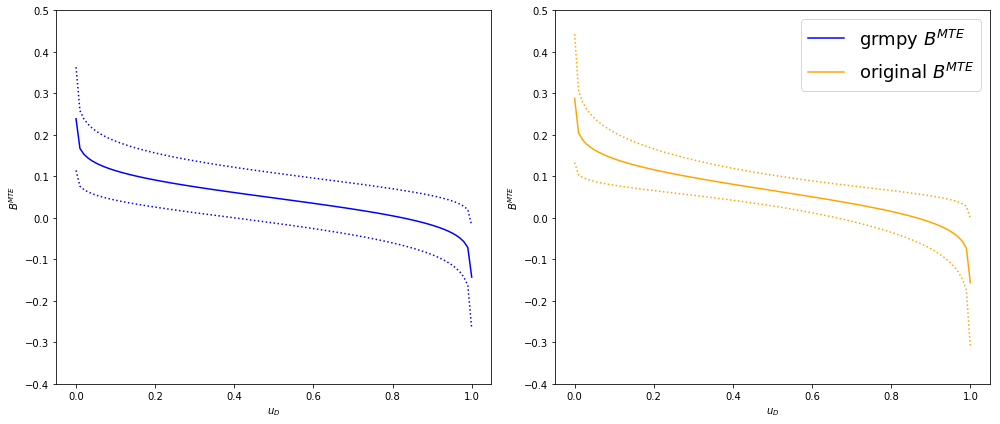

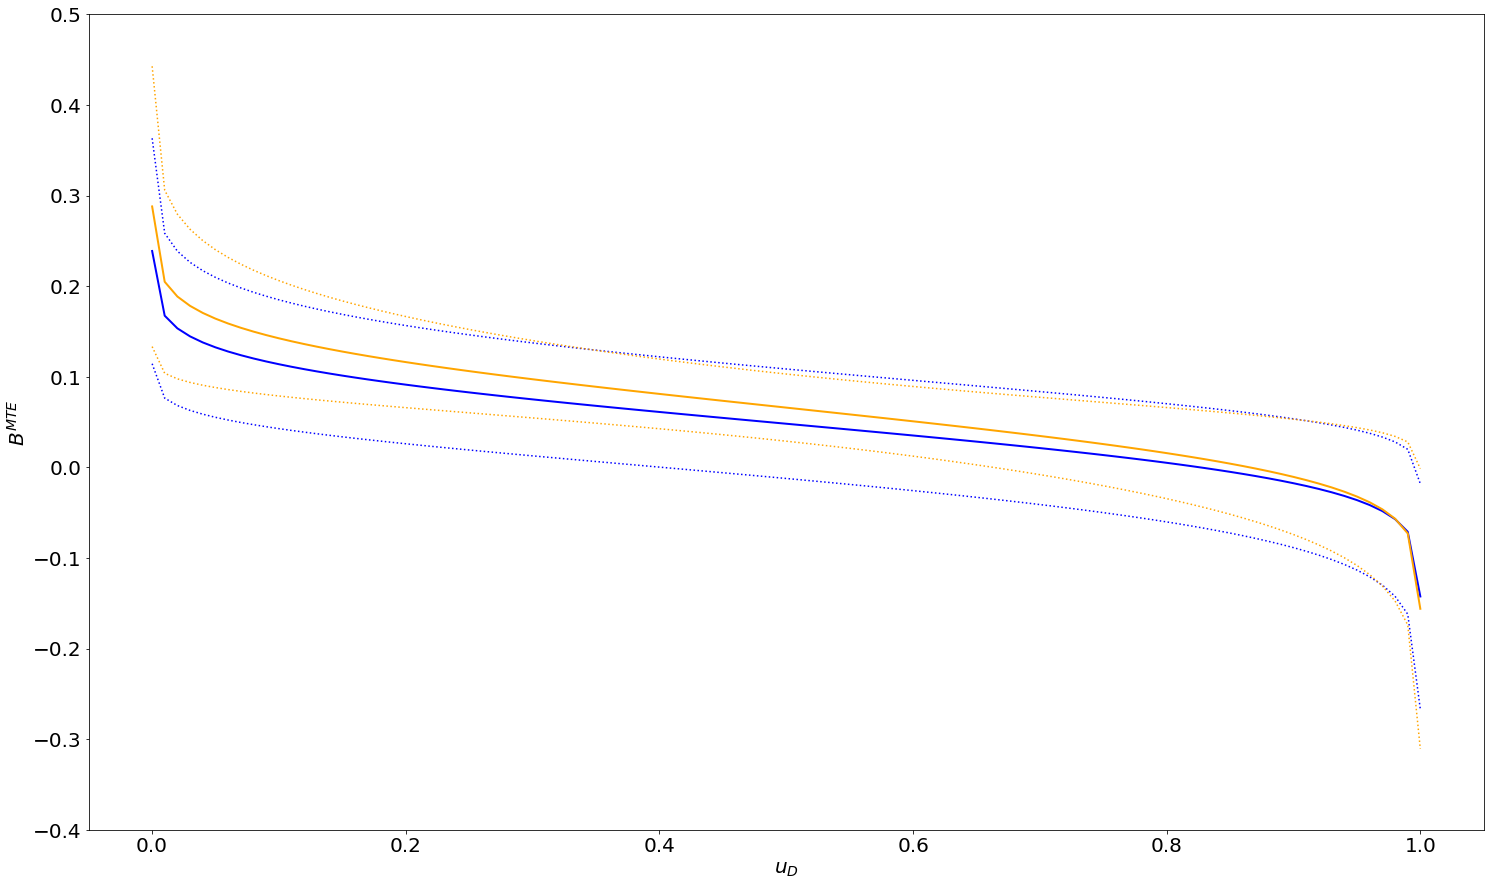

In [55]:
mte = plot_est_mte(rslt, 'files/replication.grmpy.ini')


For a detailed overview on the theoretical economic background, more application examples as well as contact informations see the [online documentation](https://grmpy.readthedocs.io/en/latest/index.html). In addition, the most current code is available on [GitHub](https://github.com/OpenSourceEconomics/grmpy).


